In [1]:
from fastai.vision import *
import pickle as pkl
import builtins

In [2]:
train_path = Path('training_patchlets')

### validation set should be from a different patch

In [3]:
class SegmentationPklLabelList(SegmentationLabelList):
    def open(self, fn):
        x = pkl.load(builtins.open(str(fn),'rb'))[None,...].astype(np.float32)
        return ImageSegment(tensor(x))

class SegmentationPklList(SegmentationItemList):
    _label_cls,_square_show_res = SegmentationPklLabelList,False
    
    def open(self, fn):
        x = pkl.load(builtins.open(str(fn),'rb'))#[0:1,:,:,0:3]
        x = x.transpose([0,3,1,2]).reshape([-1,64,64]).astype(np.float32)
        return Image(tensor(x))
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): Image(torch.clamp(x.data[0:3,:,:]*3.5,0,1)).show(ax=ax, y=y, alpha=0.2,**kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

In [4]:
def valid_patch(fn, i=0):
    return f'patch_{i}' in str(fn)

def get_mask(fn):
    return str(fn).replace('feat','targ')

def exclude_masks(fn):
    return not('targ' in str(fn.name))

In [5]:
bs = 48
classes=['No Data',        
         'Cotton',         
         'Dates',          
         'Grass',          
         'Lucern',         
         'Maize',          
         'Pecan',          
         'Vacant',         
         'Vineyard',       
         'Vineyard & Pecan']

src = (SegmentationPklList.from_folder(train_path, extensions=['.pkl'], 
                                       recurse=True, convert_mode='L')
       
       .filter_by_func(exclude_masks)
       #.use_partial_data(0.1)
       .split_by_valid_func(valid_patch)
       .label_from_func(get_mask, classes=classes)
)

In [6]:
stats_data = src.databunch(bs=128)
x,y = stats_data.one_batch()

In [7]:
means = x.mean(dim=[0,2,3])
stds = x.std(dim=[0,2,3])

In [140]:
tfms = get_transforms(    
    do_flip = True,
    flip_vert = True,
    max_rotate = 10,
    max_zoom = 1.1,
    max_lighting = 0.25,
    max_warp = 0.3,
    p_affine = 0.75,
    p_lighting = 0,
    xtra_tfms = [cutout(n_holes=(10,20), length=(3, 5), p=.85)]
)

data = (src.transform(tfms,
                      tfm_y=True)
        .databunch(bs=bs, num_workers = 0)
        .normalize(stats=(means,stds)))

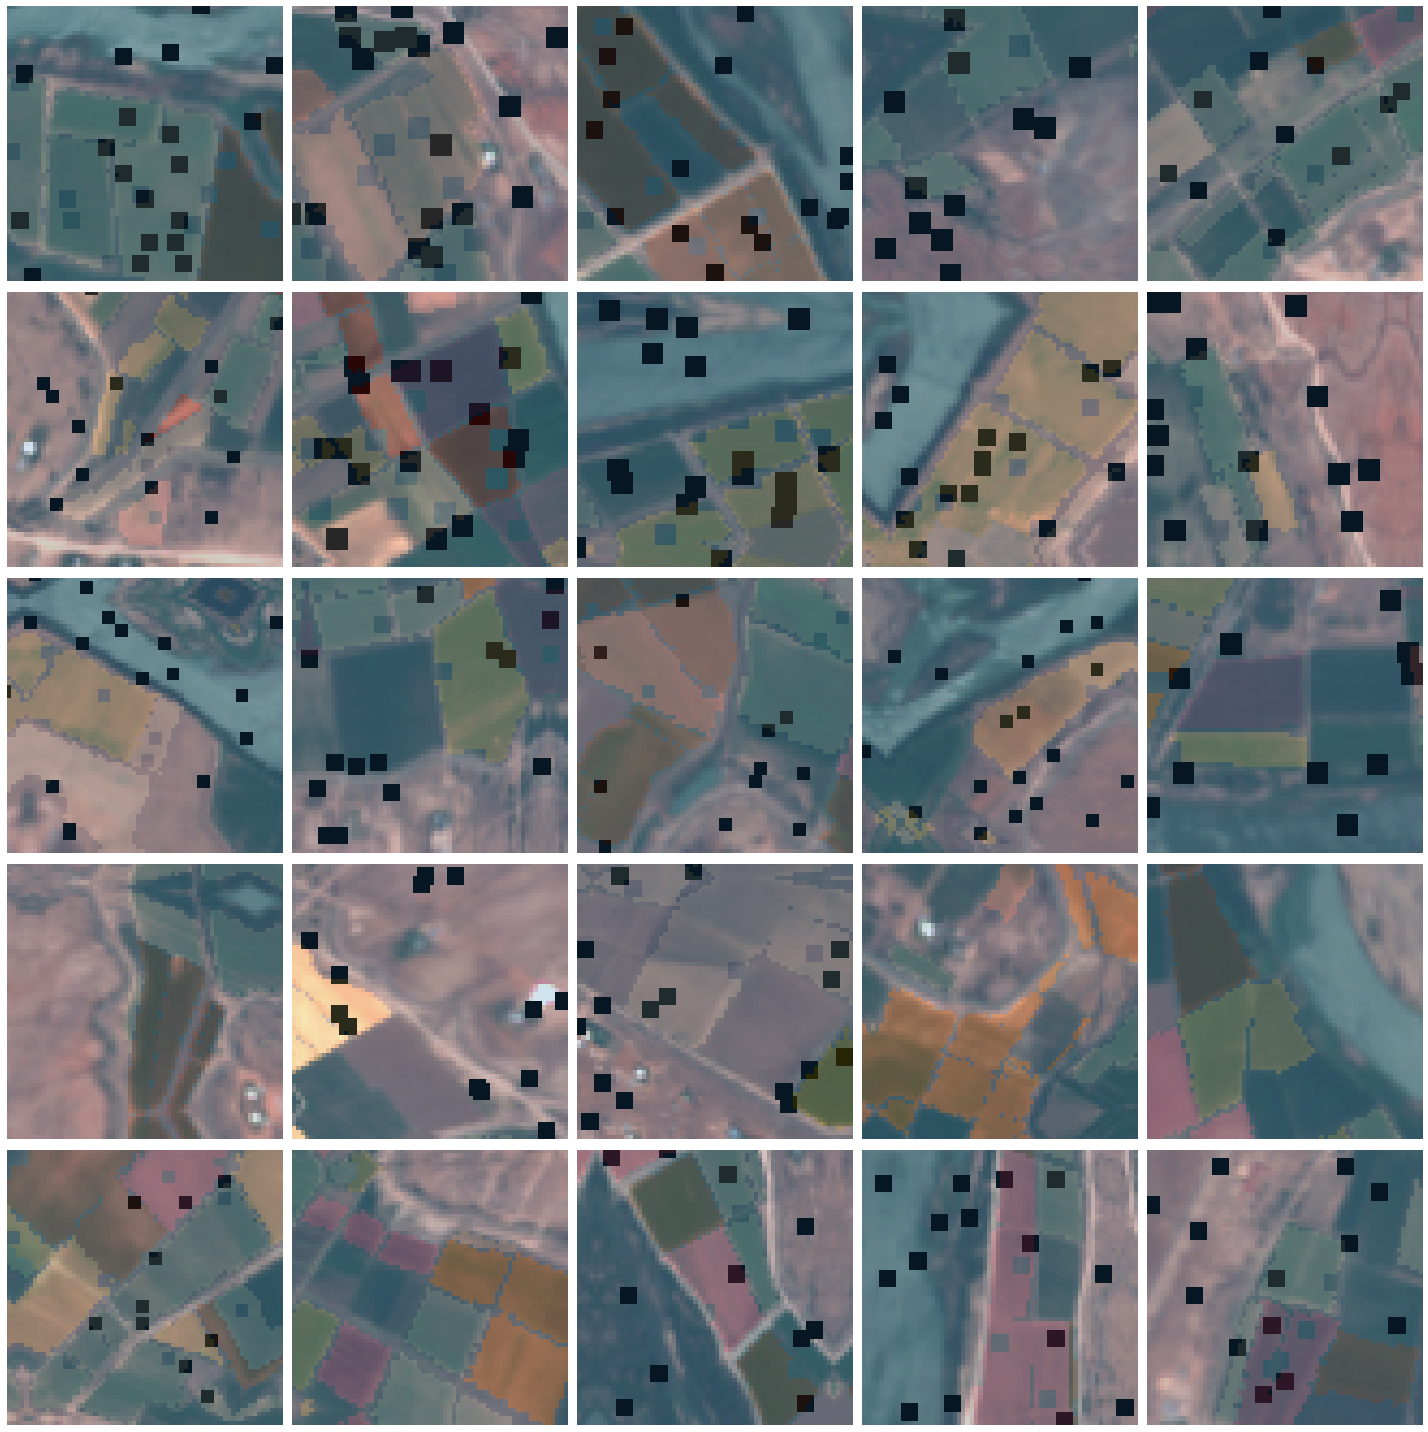

In [141]:
data.show_batch()

In [10]:
def myresnet_func(*args):
    myresnet = models.resnet50()
    myresnet.conv1 = torch.nn.Conv2d(48, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return myresnet

In [22]:
def pixel_acc(inputs, targs):
    inputs = inputs.argmax(dim=1)[:,None,...]
    return (targs[targs!=0]==inputs[targs!=0]).float().mean()

In [12]:
class myMixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = myMixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)

        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            
            new_lambd = torch.distributions.utils.broadcast_all(lambd[:,None,None,None], last_target)[0]
            
            #new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), new_lambd[:,None].float()], 1)
            new_target = torch.stack([last_target.float(), y1.float(), new_lambd.float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
            
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class myMixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) >= 5:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            lambd = target[:,2].contiguous().view(-1)
            d = (loss1 * lambd  + loss2 * (1-lambd)).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [133]:
learn = unet_learner(data, 
                     myresnet_func, 
                     loss_func=CrossEntropyFlat(axis=1,ignore_index=0),
                     metrics=[pixel_acc],
                    callback_fns=[partial(myMixUpCallback,stack_y=True)])

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [134]:
learn.fit_one_cycle(1,max_lr=1e-3, wd=0.3)

epoch,train_loss,valid_loss,pixel_acc,time
0,0.423896,0.403113,0.718694,06:31


In [ ]:
learn.recorder.plot_losses()

In [135]:
learn.save('1_epochs_32_batch_mixup_frozen')

In [ ]:
#learn.save('5_epochs_64_batch_mixup_frozen')

In [15]:
learn.load('5_epochs_64_batch_mixup_frozen');

In [17]:
learn.unfreeze()
#lr_find(learn)
#learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5,max_lr=slice(1e-4))

epoch,train_loss,valid_loss,pixel_acc,time
0,0.267559,0.455080,0.870539,05:01
1,0.264954,0.449596,0.871084,04:18
2,0.257486,0.453945,0.866257,04:18
3,0.249022,0.448058,0.868092,04:17
4,0.245799,0.439727,0.868240,04:18


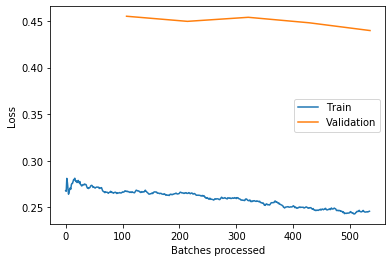

In [19]:
learn.recorder.plot_losses()

In [30]:
learn.save('5_epochs_64_batch_mixup_frozen_5_epochs_unfrozen');

In [129]:
learn.load('5_epochs_64_batch_mixup_frozen');

In [ ]:
learn.load('5_epochs_64_batch_mixup_frozen_5_epochs_unfrozen');

In [136]:
preds, targs = learn.get_preds(DatasetType.Valid)

In [131]:
# %load -n pixel_acc
def pixel_acc_per_class(inputs, targs, class_id=None):
    inputs = inputs.argmax(dim=1)[:,None,...]
    inputs = inputs[targs==class_id]
    targs = targs[targs==class_id]
    pixels = len(targs)
    if pixels > 0:
        score = ((targs[targs!=0]==inputs[targs!=0])).float().mean()
    else:
        score = -1
    return pixels, score

### 5 epochs

```
0.Cotton             0.86  on      60489 px
1.Dates             -1.00  on          0 px
2.Grass              0.32  on       2469 px
3.Lucern             0.91  on     211997 px
4.Maize              0.87  on      64922 px
5.Pecan              0.11  on      74645 px
6.Vacant             0.23  on     173867 px
7.Vineyard           0.89  on     407056 px
8.Vineyard & Pecan   0.00  on       7873 px```



### 1 Epoch

```
0.Cotton             0.84  on      60489 px
1.Dates              -1.00 on          0 px
2.Grass              0.32  on       2469 px
3.Lucern             0.94  on     211997 px
4.Maize              0.86  on      64922 px
5.Pecan              0.14  on      74645 px
6.Vacant             0.31  on     173867 px
7.Vineyard           0.86  on     407056 px
8.Vineyard & Pecan   0.00  on       7873 px```

In [137]:
for c in range(9):
    print(f'{c}.{classes[c+1]:18} {pixel_acc_per_class(preds, targs, class_id=c+1)[1]:0.2f} '
          +f' on {pixel_acc_per_class(preds, targs, class_id=c+1)[0]:10} px')

0.Cotton             0.84  on      60489 px
1.Dates              -1.00  on          0 px
2.Grass              0.32  on       2469 px
3.Lucern             0.94  on     211997 px
4.Maize              0.86  on      64922 px
5.Pecan              0.14  on      74645 px
6.Vacant             0.31  on     173867 px
7.Vineyard           0.86  on     407056 px
8.Vineyard & Pecan   0.00  on       7873 px


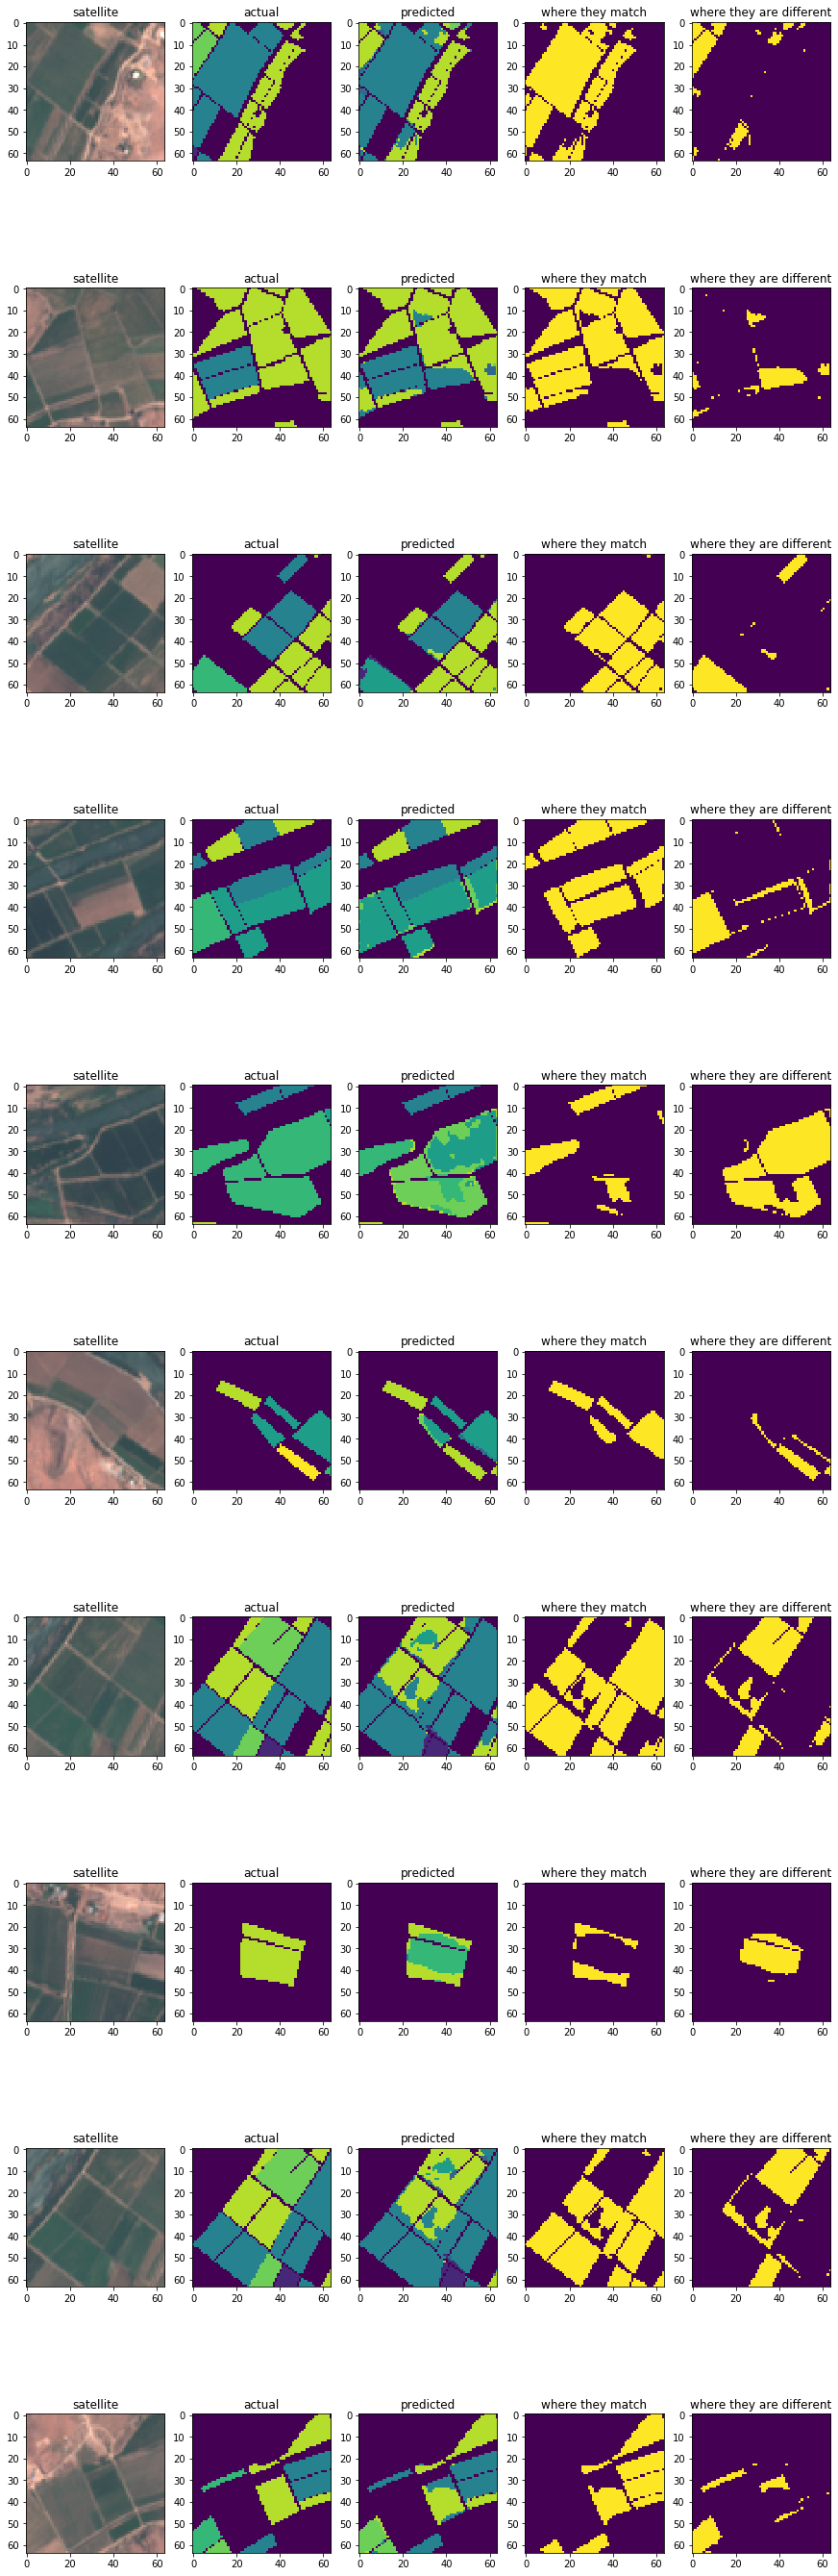

In [139]:
idxs = np.random.randint(0, len(preds), [rows])

rows = 10
plt.figure(figsize=(15,5*rows))

nc = 5

for i,j in enumerate(idxs):
    pred = preds.argmax(dim=1)[j]
    targ = targs[j].squeeze()
    pred[targ==0]=0
    
    ax = plt.subplot(rows,nc,nc*i+1)
    plt.imshow(np.clip(data.valid_ds[j][0].data[0:3].permute([1,2,0])*3.5,0,1))
    ax.set_title('satellite')
    ax = plt.subplot(rows,nc,nc*i+2)
    ax.set_title('actual')
    plt.imshow(targ, vmin=0, vmax=9)
    ax = plt.subplot(rows,nc,nc*i+3)
    ax.set_title('predicted')
    plt.imshow(pred, vmin=0, vmax=9)
    ax = plt.subplot(rows,nc,nc*i+4)
    ax.set_title('where they match')
    plt.imshow((targ==pred)&(targ!=0), vmin=0, vmax=1)
    ax = plt.subplot(rows,nc,nc*i+5)
    ax.set_title('where they are different')
    plt.imshow((targ!=pred)&(targ!=0), vmin=0, vmax=1)